## Import all required tools: SENSE CHECKING PARS is TURNED OFF. TURN IT BACK ON

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import *

%matplotlib inline


mp = ixmp.Platform()


<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


## Clone baseline and create emission bound scenario

In [2]:
# this is to import scenario from data base and clone to local
base = message_ix.Scenario(mp, model='GENIE_sandbox', scenario="cb1000")
scen = base.clone(
    "GENIE_sandbox",
    "cb1000_splitCO2transdisp",
    "1000 carbon budget with split CO2 transmission and disposal",
    keep_solution=False, 
)
scen.check_out()

year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scen.set("year")


## Split CO2 infrastructure using add_dac tool

In [3]:
# REMOVE RELATIONS
# list of parameters to remove
params = ['relation_activity']

# list of technologies to remove
techs = ['co2_tr_dis', 'bco2_tr_dis',
         'bio_istig_ccs','bio_ppl_co2scr','eth_bio_ccs','h2_bio_ccs','liq_bio_ccs',
         'c_ppl_co2scr','cement_co2scr','coal_adv_ccs','g_ppl_co2scr','gas_cc_ccs',
             'h2_coal_ccs','h2_smr_ccs','igcc_ccs','meth_coal_ccs','meth_ng_ccs','syn_liq_ccs']
rels = ['co2_trans_disp','bco2_trans_disp','CO2_Emission_Global_Total', 'CO2_Emission',]

# removing parameters
for par in params:
    scen.remove_par(par, scen.par(par,{'technology':techs,'relation':rels}))

    
    
# REMOVE PIPELIENES
# list of parameters to remove
params = ['inv_cost','fix_cost','input','capacity_factor','technical_lifetime',
          'construction_time','abs_cost_activity_soft_up','growth_activity_lo',
          'level_cost_activity_soft_lo','level_cost_activity_soft_up','relation_activity',
          'var_cost','output','emission_factor','soft_activity_lo','soft_activity_up',
          'growth_activity_up','initial_activity_up']
# list of technologies to remove
pipes = ['co2_tr_dis', 'bco2_tr_dis']
# removing parameters
for par in params:
    scen.remove_par(par, scen.par(par,{'technology':pipes}))

    
    
# REMOVE SETS    
# removing daccs from technology set
scen.remove_set('technology',pipes)
scen.remove_set('relation',rels[0:2])


**Add new set of technologies:**

In [4]:
# add related technologies
filepath = 'C:/Users/pratama/Documents/GitHub/MESSAGEix/message_ix/tutorial/dac_scenarios/data/tech_data-split_TnD_v3.yaml'
add_dac(scen,filepath=filepath)

In [5]:
# removing some pipelines parameters
newpipesnstors = ['co2_stor','co2_tr_dis', 'bco2_tr_dis']
pars2remove = ['var_cost','input','output','emission_factor','capacity_factor']
for par in pars2remove:
    df = scen.par(par,{'technology':newpipesnstors})
    df= df.loc[df['year_vtg'] != df['year_act']]
    scen.remove_par(par, df)

## Run the model

In [6]:
scen.commit(comment="emission bound with split CO2 infrastructure")
scen.set_as_default()

In [7]:
scen.solve(solve_options={'barcrossalg': '2','scaind':'0'}) # solve_options={'barcrossalg': '2','scaind':'1'}
scen.var("OBJ")["lvl"]

2609317.5

## Key variables report
- CO2_emission
- CO2_removal
- CO2_price

In [8]:
# CO2 Emission
emiss = scen.var("EMISS")
emiss = emiss.loc[(emiss['type_tec'] == 'all') & (emiss['node'] == 'World') & (emiss['emission'] == 'TCE')]
emiss_plot = emiss[['year','lvl']].set_index(['year'])

# CO2 Removal
removal = scen.var("EMISS")
removal = removal.loc[(removal['type_tec'] == 'all') & (removal['node'] == 'World') & (removal['emission'] == 'CO2_storage')]
removal_plot = removal[['year','lvl']].set_index(['year'])

# CO2 Prices
CO2Price = scen.var("PRICE_EMISSION")[['year','lvl']].set_index(['year'])

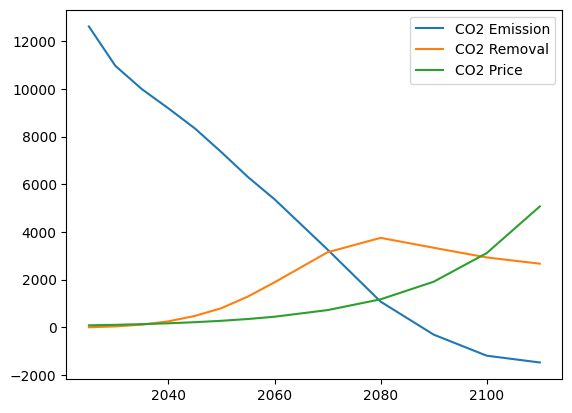

In [9]:
# Plottings
plt.plot(emiss_plot, label='CO2 Emission')
plt.plot(removal_plot, label='CO2 Removal')
plt.plot(CO2Price, label='CO2 Price')
plt.legend()
plt.show()

## Close connection

In [10]:
mp.close_db()